In [9]:
from datetime import datetime
from datetime import date
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [10]:
def read_mta(file_nums):
    path ='http://web.mta.info/developers/data/nyct/turnstile/turnstile_'
    allFiles = []
    for i in file_nums:
        allFiles.append(path + i + ".txt")
    df_list = [pd.read_csv(file) for file in allFiles]
    df = pd.concat(df_list)
    df.columns = df.columns.str.strip()
    return df

In [11]:
# last 3 months data in 2021
df = read_mta(['210703', '210710', '210717', '210724', '210731', '210807', '210814', '210821', '210828', '210904', '210911', '210918', '210925'])

In [12]:
df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

In [14]:
# remove duplicates
df = df[df.DESC != 'RECOVR AUD']
df = df[df.TIME != '04:00:00']
# Sanity check to verify that "C/A", "UNIT", "SCP", "STATION", "DATE_TIME" is unique
(df
 .groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE', 'TIME'])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head()


,C/A,UNIT,SCP,STATION,DATE,TIME,ENTRIES
0,A002,R051,02-00-00,59 ST,06/26/2021,00:00:00,1
1652303,R138,R293,00-03-01,34 ST-PENN STA,07/23/2021,06:00:00,1
1652305,R138,R293,00-03-01,34 ST-PENN STA,07/23/2021,14:00:00,1
1652306,R138,R293,00-03-01,34 ST-PENN STA,07/23/2021,18:00:00,1
1652307,R138,R293,00-03-01,34 ST-PENN STA,07/23/2021,22:00:00,1


In [15]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/26/2021,00:00:00,REGULAR,7592792,2595706
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/26/2021,08:00:00,REGULAR,7592816,2595729
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/26/2021,12:00:00,REGULAR,7592870,2595762
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/26/2021,16:00:00,REGULAR,7592992,2595791
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/26/2021,20:00:00,REGULAR,7593116,2595809


In [81]:
df['DATETIME'] = pd.to_datetime(df.DATE + ' ' + df.TIME)

In [82]:
df = df.set_index(['DATETIME'])

In [22]:
# filter dataset in all day
daily = df.between_time('00:00:00', '23:59:00')
daily.tail()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
DATETIME,,,,,,,,,,,
2021-09-24 05:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/24/2021,05:00:00,REGULAR,5554,645
2021-09-24 09:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/24/2021,09:00:00,REGULAR,5554,645
2021-09-24 13:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/24/2021,13:00:00,REGULAR,5554,645
2021-09-24 17:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/24/2021,17:00:00,REGULAR,5554,646
2021-09-24 21:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/24/2021,21:00:00,REGULAR,5554,646


In [23]:
# subtract max from min for each turnstile to get entries
daily_turn = (daily.groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE'])['ENTRIES'].max()\
           -daily.groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE'])['ENTRIES'].min()).reset_index()

In [24]:
#explore outliers
daily_turn['ENTRIES'].describe()

count    4.541230e+05
mean     9.849510e+03
std      2.963744e+06
min      0.000000e+00
25%      7.700000e+01
50%      2.450000e+02
75%      4.870000e+02
max      1.383110e+09
Name: ENTRIES, dtype: float64

In [26]:
daily_turn['ENTRIES'].sort_values(ascending = True).tail(30)

159945       1198434
118076       1605073
417659       1684112
369603       1694313
340050       1953459
311466       3102523
307329       3154026
121279       4293220
163558       5405491
221543       6214017
359378       6250019
442847       6481441
141764       7249292
135069      10485760
307222      11123654
227900      15689361
185716      15740062
194179      16034825
81605       33377049
435450      50018550
333437      50111070
155656      66781958
155739      67109617
155648      67109618
122387     117440512
74423      167087887
387179     200533228
393813     943216066
359490    1040931923
447755    1383110319
Name: ENTRIES, dtype: int64

In [28]:
# removing values that appear to be counter resets
daily_turn = daily_turn[daily_turn.ENTRIES <= 11000]

In [37]:
daily_turn.head()
#daily_turn.shape

,C/A,UNIT,SCP,STATION,DATE,ENTRIES
0,A002,R051,02-00-00,59 ST,06/26/2021,324
1,A002,R051,02-00-00,59 ST,06/27/2021,252
2,A002,R051,02-00-00,59 ST,06/28/2021,501
3,A002,R051,02-00-00,59 ST,06/29/2021,472
4,A002,R051,02-00-00,59 ST,06/30/2021,520


In [83]:
# add up total daily entries per station
daily_station = daily_turn.groupby(['STATION', 'DATE']).sum().reset_index()
daily_station['DATE'] = pd.to_datetime(daily_station['DATE'])
daily_station.tail()

,STATION,DATE,ENTRIES
34434,ZEREGA AV,2021-09-20,1374
34435,ZEREGA AV,2021-09-21,1405
34436,ZEREGA AV,2021-09-22,1431
34437,ZEREGA AV,2021-09-23,1399
34438,ZEREGA AV,2021-09-24,1348


In [43]:
# summing for whole month
daily_month = daily_station.groupby(['STATION'])['ENTRIES'].sum().reset_index()
daily_month = daily_month.set_index('STATION')

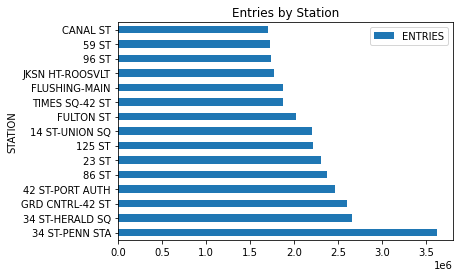

In [44]:
# determine busiest stations

topsts = daily_month.sort_values('ENTRIES', ascending=False).head(15)
topsts.head()
topsts.plot(kind='barh', title='Entries by Station')

In [56]:
# limit to 34 ST-PENN STA at turnstile level
penn = df[df['STATION'] == '34 ST-PENN STA']

In [57]:
#show the numbers of raws & columns
penn.shape


(48122, 11)

In [62]:
penn.tail()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
DATETIME,,,,,,,,,,,
2021-09-24 06:00:00,R142,R293,01-06-01,34 ST-PENN STA,123ACE,IRT,09/24/2021,06:00:00,REGULAR,68097697,18814518
2021-09-24 10:00:00,R142,R293,01-06-01,34 ST-PENN STA,123ACE,IRT,09/24/2021,10:00:00,REGULAR,68097722,18814652
2021-09-24 14:00:00,R142,R293,01-06-01,34 ST-PENN STA,123ACE,IRT,09/24/2021,14:00:00,REGULAR,68097772,18814759
2021-09-24 18:00:00,R142,R293,01-06-01,34 ST-PENN STA,123ACE,IRT,09/24/2021,18:00:00,REGULAR,68097854,18814904
2021-09-24 22:00:00,R142,R293,01-06-01,34 ST-PENN STA,123ACE,IRT,09/24/2021,22:00:00,REGULAR,68097914,18815021


In [68]:
turnstiles = penn['SCP'].unique()

In [69]:
masked_dfs = []
for i in turnstiles:
    mask = penn[((penn["C/A"] == "R142") &
    (penn["UNIT"] == "R293") &
    (penn["SCP"] ==  i) &
    (penn["STATION"] == "34 ST-PENN STA"))]
           
    mask['DIFFS'] = mask['ENTRIES'].diff()
    masked_dfs.append(mask)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [70]:
entries_turn = pd.concat(masked_dfs)

In [71]:
entries_turn.tail()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DIFFS
DATETIME,,,,,,,,,,,,
2021-09-24 06:00:00,R142,R293,01-06-01,34 ST-PENN STA,123ACE,IRT,09/24/2021,06:00:00,REGULAR,68097697,18814518,0.0
2021-09-24 10:00:00,R142,R293,01-06-01,34 ST-PENN STA,123ACE,IRT,09/24/2021,10:00:00,REGULAR,68097722,18814652,25.0
2021-09-24 14:00:00,R142,R293,01-06-01,34 ST-PENN STA,123ACE,IRT,09/24/2021,14:00:00,REGULAR,68097772,18814759,50.0
2021-09-24 18:00:00,R142,R293,01-06-01,34 ST-PENN STA,123ACE,IRT,09/24/2021,18:00:00,REGULAR,68097854,18814904,82.0
2021-09-24 22:00:00,R142,R293,01-06-01,34 ST-PENN STA,123ACE,IRT,09/24/2021,22:00:00,REGULAR,68097914,18815021,60.0


In [72]:
#remove NaN values and negative values (i.e. counter resets)
entries_turn.dropna(inplace=True)
entries_turn = entries_turn[entries_turn['DIFFS'] >= 0]

In [73]:

# now have turnstile entries per four period (diffs column)
entries_turn.tail()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DIFFS
DATETIME,,,,,,,,,,,,
2021-09-24 06:00:00,R142,R293,01-06-01,34 ST-PENN STA,123ACE,IRT,09/24/2021,06:00:00,REGULAR,68097697,18814518,0.0
2021-09-24 10:00:00,R142,R293,01-06-01,34 ST-PENN STA,123ACE,IRT,09/24/2021,10:00:00,REGULAR,68097722,18814652,25.0
2021-09-24 14:00:00,R142,R293,01-06-01,34 ST-PENN STA,123ACE,IRT,09/24/2021,14:00:00,REGULAR,68097772,18814759,50.0
2021-09-24 18:00:00,R142,R293,01-06-01,34 ST-PENN STA,123ACE,IRT,09/24/2021,18:00:00,REGULAR,68097854,18814904,82.0
2021-09-24 22:00:00,R142,R293,01-06-01,34 ST-PENN STA,123ACE,IRT,09/24/2021,22:00:00,REGULAR,68097914,18815021,60.0


In [84]:
# add entries across turnstiles by time
entries_turn = entries_turn.reset_index()
ct = entries_turn.groupby(['DATETIME'])['DIFFS'].sum().reset_index()

In [85]:

ct.set_index(['DATETIME'], inplace=True)
ct.tail()

,DIFFS
DATETIME,
2021-09-24 06:00:00,9.0
2021-09-24 10:00:00,241.0
2021-09-24 14:00:00,531.0
2021-09-24 18:00:00,977.0
2021-09-24 22:00:00,575.0


In [86]:
#1month
we1 = ct[(ct.index > '2021-07-4 05:00:00') & (ct.index < '2021-07-6 00:00:00')]
wd1 = ct[(ct.index > '2021-07-6 05:00:00') & (ct.index < '2021-07-11 00:00:00')]
we2 = ct[(ct.index > '2021-07-11 05:00:00') & (ct.index < '2021-07-13 00:00:00')]
wd2 = ct[(ct.index > '2021-07-13 05:00:00') & (ct.index < '2021-07-18 00:00:00')]
we3 = ct[(ct.index > '2021-07-18 05:00:00') & (ct.index < '2021-07-20 00:00:00')]
wd3 = ct[(ct.index > '2021-07-20 05:00:00') & (ct.index < '2021-07-25 00:00:00')]

#2month
we4 = ct[(ct.index > '2021-08-04 05:00:00') & (ct.index < '2021-08-06 00:00:00')]
wd4 = ct[(ct.index > '2021-08-06 05:00:00') & (ct.index < '2021-08-11 00:00:00')]
we5 = ct[(ct.index > '2021-08-11 05:00:00') & (ct.index < '2021-08-13 00:00:00')]
wd5 = ct[(ct.index > '2021-08-13 05:00:00') & (ct.index < '2021-08-18 00:00:00')]
we6 = ct[(ct.index > '2021-08-18 05:00:00') & (ct.index < '2021-08-20 00:00:00')]
wd6 = ct[(ct.index > '2021-08-20 05:00:00') & (ct.index < '2021-08-25 00:00:00')]
#3month
we7 = ct[(ct.index > '2021-09-04 05:00:00') & (ct.index < '2021-09-06 00:00:00')]
wd7 = ct[(ct.index > '2021-09-06 05:00:00') & (ct.index < '2021-09-11 00:00:00')]
we8 = ct[(ct.index > '2021-09-11 05:00:00') & (ct.index < '2021-09-13 00:00:00')]
wd8 = ct[(ct.index > '2021-09-13 05:00:00') & (ct.index < '2021-09-18 00:00:00')]
we9 = ct[(ct.index > '2021-09-18 05:00:00') & (ct.index < '2021-09-20 00:00:00')]
wd9 = ct[(ct.index > '2021-09-20 05:00:00') & (ct.index < '2021-09-25 00:00:00')]

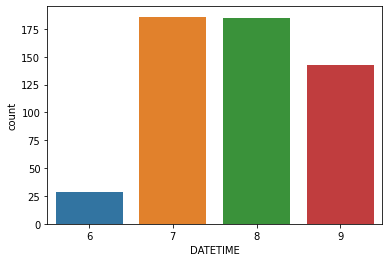

In [94]:
july = ct[(ct.index > '2021-07-01 00:00:00') & (ct.index < '2021-07-30 05:00:00')]
august = ct[(ct.index > '2021-08-01 00:00:00') & (ct.index < '2021-08-28 05:00:00')]
septemper = ct[(ct.index > '2021-09-01 00:00:00') & (ct.index < '2021-09-30 05:00:00')]
sns.countplot(x= ct.index.month , data = ct )

Text(0, 0.5, 'People Entries')

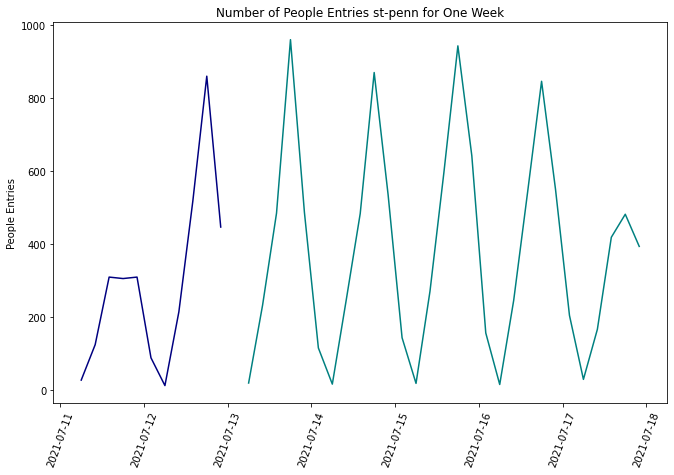

In [95]:
plt.figure(figsize=(11,7))


plt.xticks(rotation=70)
plt.plot(we2, color = 'navy')
plt.plot(wd2, color = '#008080')
plt.title('Number of People Entries st-penn for One Week')
plt.ylabel('People Entries')